<a href="https://colab.research.google.com/github/nickwinters1/DS-Unit-4-Sprint-2-Neural-Networks/blob/master/LS_DS_423_Keras_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [0]:
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

Using TensorFlow backend.
/Users/lambda_school_loaner_95/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [0]:
x_train.shape

(404, 13)

In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

np.random.seed(42)

In [0]:
model = Sequential()

model.add(Dense(10, input_shape=(13,), activation='relu'))

model.add(Dense(5, activation='relu'))

model.add(Dense(1, activation='linear'))

In [0]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

history = model.fit(x_train, y_train, batch_size=10, epochs=2000, validation_split=.1, verbose=0)

scores = model.evaluate(x_test, y_test)
print(f"{model.metrics_names[1]}: {scores[1]}")

Instructions for updating:
Use tf.cast instead.
102/102 [==============================] - 0s 29us/step
mean_squared_error: 20.057949290556067


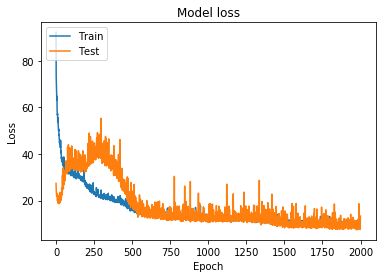

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()

lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [0]:
pred = lin_reg.predict(x_test)

mean_squared_error(pred, y_test)

0.03838042

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [0]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 2s 0us/step


In [0]:
batch_size = 50
num_class = 10
epochs = 100

In [0]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [0]:
x_test = x_test.reshape(10000, 784)
x_train = x_train.reshape(60000, 784)

In [0]:
type(x_train[0][0])

numpy.uint8

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [0]:
y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

In [0]:
fashion_mnist_model = Sequential()

fashion_mnist_model.add(Dense(16, input_shape=(784,), activation='relu'))

fashion_mnist_model.add(Dense(16, activation='relu'))

fashion_mnist_model.add(Dense(10, activation='softmax'))

fashion_mnist_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

fashion_mnist_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_15 (Dense)             (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_fashion_mnist = fashion_mnist_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=.1, verbose=0)

scores = fashion_mnist_model.evaluate(x_test, y_test)
print(f"{fashion_mnist_model.metrics_names[1]}: {scores[1]*100}")

10000/10000 [==============================] - 0s 33us/step
acc: 77.32


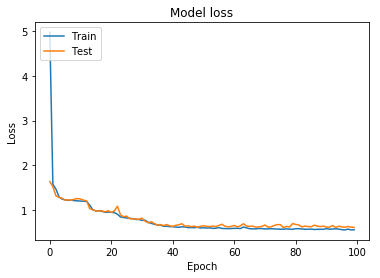

In [0]:

plt.plot(history_fashion_mnist.history['loss'])
plt.plot(history_fashion_mnist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.